## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Моисеенков И. П. |
|---------|--------|
| Группа  | М8О-308Б-19      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [ ]:
# !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

Зафиксируем рандом стейт, чтобы результаты были воспроизводимые

In [1]:
import numpy as np

random_state = 0xDEAD

Теперь загружаем датасет:

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
features = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [4]:
features.shape, labels.shape

((42000, 784), (42000,))

6

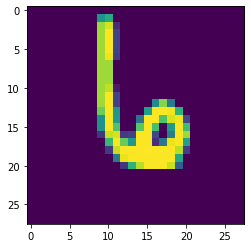

In [5]:
import pylab

pylab.imshow(features[123].reshape(28,28))
labels[123]

# Реализация слоев нейросети

## Линейный слой (перцептрон)

In [6]:
class Linear:
    def __init__(self, dim_in, dim_out):
        np.random.seed(random_state)
        self.W = np.random.normal(0, 1./np.sqrt(dim_in), (dim_in, dim_out))
        self.b = np.zeros((1, dim_out))
    
    def forward(self, X):
        self.X = X  # (batch_size, dim_in)
        return X @ self.W + self.b  # (batch_size, dim_out)
    
    def backward(self, dz):
        dx = dz @ self.W.T
        self.dW = self.X.T @ dz
        self.db = dz.sum(axis=0)
        return dx
    
    def parameters(self):
        # возвращает список своих параметров
        return [self.W, self.b]
    
    def grad_parameters(self):
        # возвращает список градиентов для своих параметров
        return [self.dW, self.db]

## Функции активации

In [7]:
class Softmax:
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z
        
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

In [8]:
class Tanh:
    def forward(self, x):
        y = np.tanh(x)
        self.y = y
        return y
    
    def backward(self, dy):
        return (1.0 - self.y**2) * dy

In [9]:
class ReLU:
    def forward(self, input):
        self.input = input # пригодится для вычисления производной
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, dy):
        mask = self.input > 0
        return np.multiply(dy, mask)


## Функции потерь

In [10]:
class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y + 1e-8)
        return -log_prob.mean()

    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / (np.clip(self.p, 1e-8, 1 - 1e-8)) # чтобы не было деления на ноль

## Модель

In [11]:
class Model:
    def __init__(self):
        self.layers = []
    
    def add(self, l):
        self.layers.append(l)
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def parameters(self):
        # получить список всех обучаемых параметров модели
        params = []
        for l in self.layers:
            if 'parameters' in l.__dir__():
                params += l.parameters()
        return params
    
    def grad_parameters(self):
        # получить список градиентов для всех обучаемых параметров модели
        grads = []
        for l in self.layers:
            if 'grad_parameters' in l.__dir__():
                grads += l.grad_parameters()
        return grads

## Оптимизаторы

In [12]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def step(self, params, gradients):
        for weights, gradient in zip(params, gradients):
            weights -= self.lr * gradient

# Инференс

Опишем функцию для получения предсказания модели

In [13]:
def predict(model, picture):
    pylab.imshow(picture.reshape(28,28))
    y_pred = model.forward(picture)
    print('Prediction:', np.argmax(y_pred, axis=1)[0])

Функция для построения confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

def print_confusion_matrix(model, X_test, y_test):
    y_pred = model.forward(X_test)
    print(confusion_matrix(y_test, np.argmax(y_pred, axis=1), labels=list(range(10))))

# Обучение моделей

Функция для обучения и валидации модели:

In [16]:
from matplotlib import pyplot as plt

In [17]:
def train_model(model, X_train, y_train, X_test, y_test, epochs_num, batch_size, optimizer, criterion):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        # training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # forward pass
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            cur_train_loss += loss

            # backward pass
            dloss = criterion.backward(loss)
            dparams = model.backward(dloss)
            optimizer.step(model.parameters(), model.grad_parameters())

            # count metrics
            cur_train_acc += (y_batch.squeeze() == np.argmax(y_pred, axis=1)).sum()
            
        # testing
        for i in range(0, len(X_test), batch_size):
            X_batch = X_test[i:i+batch_size]
            y_batch = y_test[i:i+batch_size]
            
            y_pred = model.forward(X_batch)
            cur_test_acc += (y_batch.squeeze() == np.argmax(y_pred, axis=1)).sum()

            loss = criterion.forward(y_pred, y_batch)
            cur_test_loss += loss

        
        train_acc_history.append(cur_train_acc / len(X_train))
        test_acc_history.append(cur_test_acc / len(X_test))
        train_loss_history.append(cur_train_loss / len(X_train))
        test_loss_history.append(cur_test_loss / len(X_test))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [18]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [19]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

## Однослойный перцептрон

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8, random_state=random_state)

In [21]:
perceptron_1l = Model()
perceptron_1l.add(Linear(784, 10))
perceptron_1l.add(Softmax())

optimizer = SGD(1e-5)
criterion = CrossEntropyLoss()

perceptron_1l_stats = train_model(perceptron_1l, X_train, y_train, X_test, y_test, 50, 16, optimizer, criterion)

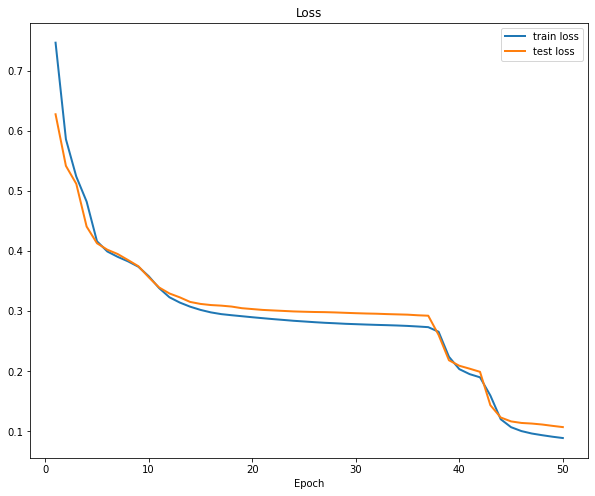

In [22]:
plot_loss_history(perceptron_1l_stats[0], perceptron_1l_stats[1])

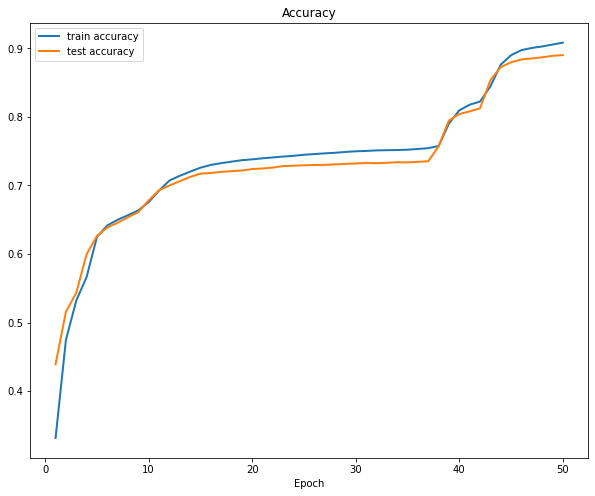

In [23]:
plot_acc_history(perceptron_1l_stats[2], perceptron_1l_stats[3])

In [24]:
print('Final accuracy =', perceptron_1l_stats[3][-1])

Final accuracy = 0.8901190476190476


In [26]:
print_confusion_matrix(perceptron_1l, X_test, y_test)

[[787   0   4   1   1  10  15   1   0   2]
 [  0 888   3   7   0   3   3   1  12   1]
 [ 20   4 723  16  23   4  12  29  31   9]
 [  1   2  24 755   0  47   9   8  32  16]
 [  1   2   7   2 736   0   6   4  15  39]
 [ 16   4  10  28  10 609  19   2  36  10]
 [  7   1   6   2   7  16 786   1   5   1]
 [  6   5  17   4  16   1   1 744   5  36]
 [  5  16   6  24   5  31   7   4 688  10]
 [ 15   1   4  13  26  10   0  25  22 761]]


Большая часть данных на диагонали - это значит, что модель классифицирует такие числа верно

Параметры обучения:
* 1 линейный слой
* 50 эпох
* batch size = 16
* learning rate = 1e-5
* loss - cross entropy

Prediction: 4


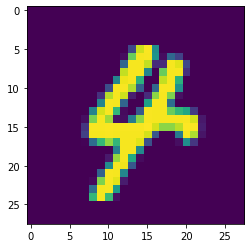

In [27]:
predict(perceptron_1l, X_test[228])

Prediction: 8


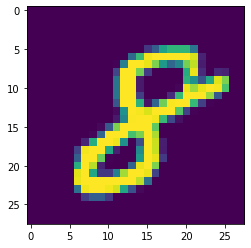

In [28]:
predict(perceptron_1l, X_test[1337])

## Многослойный перцептрон

Попробуем использовать два линейных слоя. Между ними будет функция активации. Попробуем использовать в качестве функции активации гиперболический тангенс и релу.

В качестве лосса везде будем использовать кросс-энтропию, т.к. это наилучший вариант для задачи классификации.

### Tanh

In [53]:
perceptron_2l_tanh = Model()
perceptron_2l_tanh.add(Linear(784, 128))
perceptron_2l_tanh.add(Tanh())
perceptron_2l_tanh.add(Linear(128, 10))
perceptron_2l_tanh.add(Softmax())

optimizer = SGD(1e-5)
criterion = CrossEntropyLoss()

perceptron_2l_tanh_stats = train_model(perceptron_2l_tanh, X_train, y_train, X_test, y_test, 100, 16, optimizer, criterion)

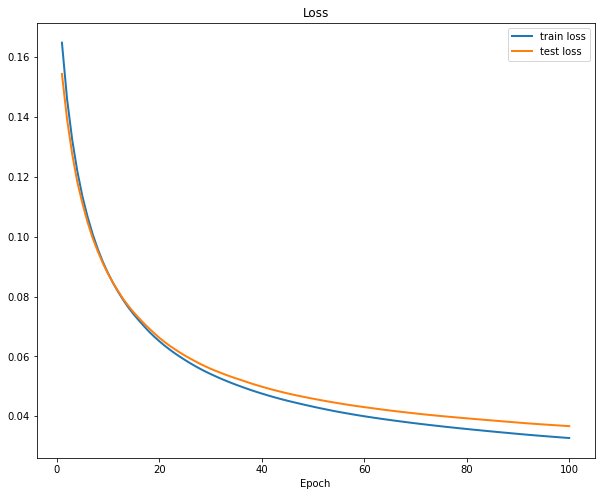

In [54]:
plot_loss_history(perceptron_2l_tanh_stats[0], perceptron_2l_tanh_stats[1])

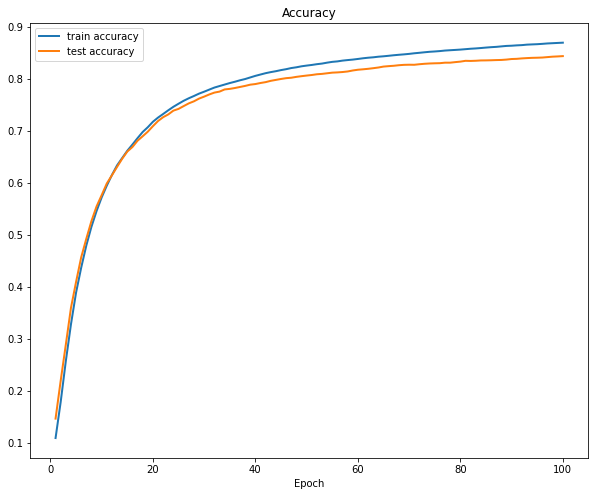

In [55]:
plot_acc_history(perceptron_2l_tanh_stats[2], perceptron_2l_tanh_stats[3])

In [56]:
print('Final accuracy =', perceptron_2l_tanh_stats[3][-1])

Final accuracy = 0.8430952380952381


Prediction: 4


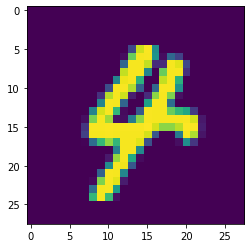

In [57]:
predict(perceptron_2l_tanh, X_test[228])

Prediction: 8


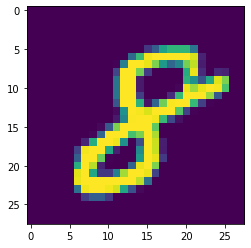

In [58]:
predict(perceptron_2l_tanh, X_test[1337])

In [59]:
print_confusion_matrix(perceptron_2l_tanh, X_test, y_test)

[[757   0   8  10   1  15  15  10   4   1]
 [  0 890   3   4   0   1   4   3  12   1]
 [ 17  13 692  36  21   6  24  28  29   5]
 [  9   4  48 721   6  41  12  19  22  12]
 [  2   3  10   4 677   4  18   6  12  76]
 [ 23   9   9  51  16 551  27   4  39  15]
 [ 16   3  15   2  13  12 755   1  14   1]
 [  5  15  13   7  13   2   2 724  10  44]
 [  7  16  11  46   4  36  12  10 638  16]
 [  8   5  21  21  60   4   2  63  16 677]]


С использованием гиперболического тангенса смогли получить точность в 84,3%

Параметры обучения:
* 2 линейных слоя. Промежуточный имеет размерность 128
* 100 эпох
* batch size = 16
* learning rate = 1e-5
* loss - cross entropy

### ReLU

In [36]:
perceptron_2l_relu = Model()
perceptron_2l_relu.add(Linear(784, 64))
perceptron_2l_relu.add(ReLU())
perceptron_2l_relu.add(Linear(64, 10))
perceptron_2l_relu.add(Softmax())

optimizer = SGD(1e-5)
criterion = CrossEntropyLoss()

perceptron_2l_relu_stats = train_model(perceptron_2l_relu, X_train, y_train, X_test, y_test, 50, 16, optimizer, criterion)

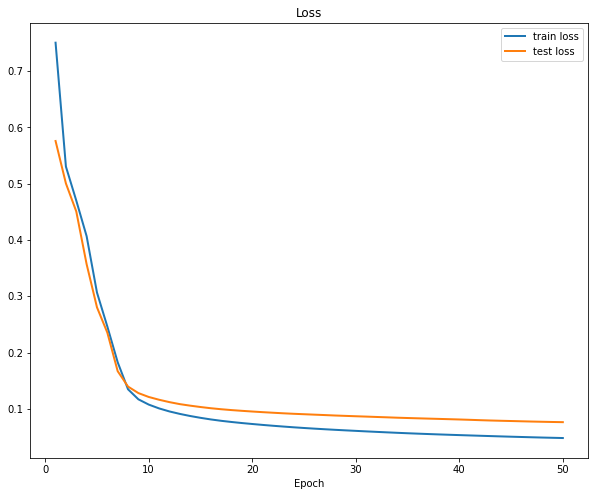

In [37]:
plot_loss_history(perceptron_2l_relu_stats[0], perceptron_2l_relu_stats[1])

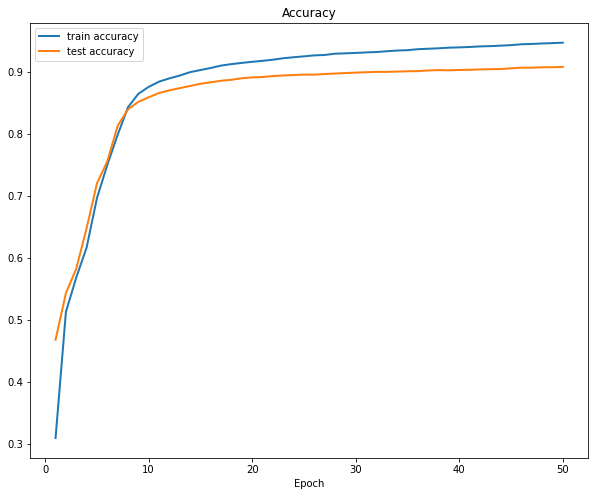

In [38]:
plot_acc_history(perceptron_2l_relu_stats[2], perceptron_2l_relu_stats[3])

In [39]:
print('Final accuracy =', perceptron_2l_relu_stats[3][-1])

Final accuracy = 0.9079761904761905


Prediction: 4


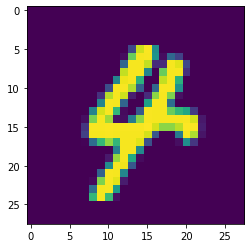

In [40]:
predict(perceptron_2l_relu, X_test[228])

Prediction: 8


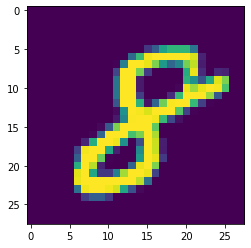

In [41]:
predict(perceptron_2l_relu, X_test[1337])

In [42]:
print_confusion_matrix(perceptron_2l_relu, X_test, y_test)

[[789   0   5   2   1   6  14   2   1   1]
 [  0 890   7   4   2   1   1   4   8   1]
 [  8   9 760  14  13   9   9  29  15   5]
 [  2   2  24 789   0  25  10  12  23   7]
 [  1   0   1   0 753   0   9   7   5  36]
 [ 14   2   6  24  12 641  15   2  19   9]
 [ 10   6   1   0   8  12 790   0   3   2]
 [  2   8  15   4  17   3   1 758   5  22]
 [  7  15   7  17   1  12  10   5 714   8]
 [  9   1   4  20  49   7   2  29  13 743]]


ReLU - быстрая и работающая функция активации. С ее помощью смогли классифицировать цифры с точностью 90,8%. Это наилучший результат, который я смог получить.

Параметры обучения:
* 2 линейных слоя. Промежуточный имеет размерность 64
* 50 эпох
* batch size = 16
* learning rate = 1e-5
* loss - cross entropy

# Fashion MNIST

Попробуем классифицировать одежду с помощью перцептронов.

Скачаем и посмотрим на другой датасет.

In [51]:
import pandas as pd

train_fashion = pd.read_csv('fashion-mnist_train.csv')
test_fashion = pd.read_csv('fashion-mnist_test.csv')

In [52]:
train_fashion.shape, test_fashion.shape

((60000, 785), (10000, 785))

In [86]:
X_train_fashion = np.array(train_fashion.drop('label', axis=1))
y_train_fashion = np.array(train_fashion['label'])
X_test_fashion = np.array(test_fashion.drop('label', axis=1))
y_test_fashion = np.array(test_fashion['label'])

0

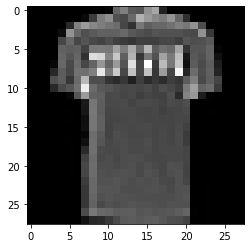

In [88]:
pylab.imshow(X_train_fashion[122].reshape(28,28), cmap='gray')
y_train_fashion[122]

### Однослойный перцептрон

In [94]:
perceptron_1l_fashion = Model()
perceptron_1l_fashion.add(Linear(784, 10))
perceptron_1l_fashion.add(Softmax())

optimizer = SGD(3e-5)
criterion = CrossEntropyLoss()

perceptron_1l_stats_fashion = train_model(perceptron_1l_fashion,
                                          X_train_fashion, y_train_fashion, 
                                          X_test_fashion, y_test_fashion, 
                                          100, 16, optimizer, criterion)

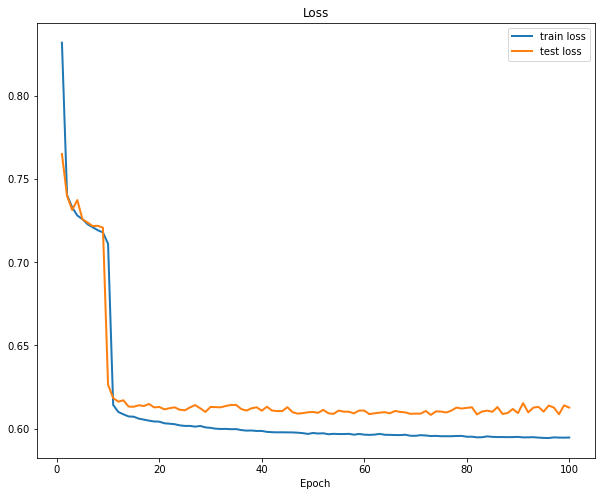

In [95]:
plot_loss_history(perceptron_1l_stats_fashion[0], perceptron_1l_stats_fashion[1])

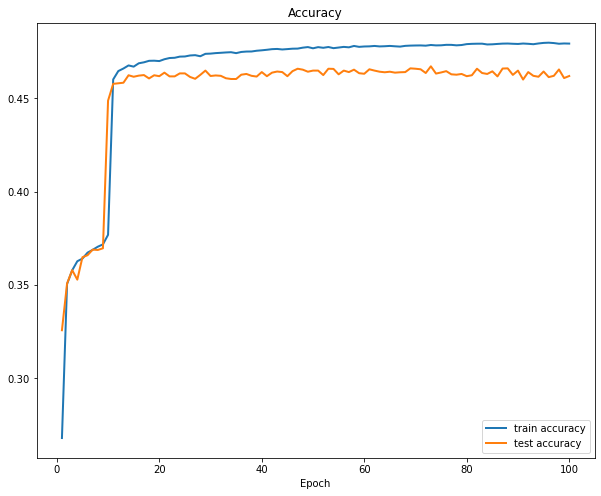

In [96]:
plot_acc_history(perceptron_1l_stats_fashion[2], perceptron_1l_stats_fashion[3])

In [97]:
print('Final accuracy =', perceptron_1l_stats_fashion[3][-1])

Final accuracy = 0.462


In [98]:
print_confusion_matrix(perceptron_1l_fashion, X_test_fashion, y_test_fashion)

[[960   0  33   0   0   3   0   4   0   0]
 [928   0  65   0   0   1   0   0   0   6]
 [ 42   0 955   0   0   2   0   1   0   0]
 [855   0 124   0   0   0   0   1   0  20]
 [ 76   0 923   0   0   1   0   0   0   0]
 [  4   0   2   0   0 871   0  53   0  70]
 [383   0 615   0   0   1   0   0   0   1]
 [  0   0   0   0   0  31   0 862   0 107]
 [ 91   0 466   0   0 399   0  37   0   7]
 [  0   0   0   0   0  10   0  18   0 972]]


Видим, что однослойный перцептрон плохо справляется в фешен мнистом. Получили точность всего 46,2%

### Двуслойный перцептрон

Обучим двуслойный перцептрон. Будем использовать функцию активации ReLU.

In [109]:
perceptron_2l_relu_fashion = Model()
perceptron_2l_relu_fashion.add(Linear(784, 64))
perceptron_2l_relu_fashion.add(ReLU())
perceptron_2l_relu_fashion.add(Linear(64, 10))
perceptron_2l_relu_fashion.add(Softmax())

optimizer = SGD(1e-5)
criterion = CrossEntropyLoss()

perceptron_2l_relu_stats_fashion = train_model(perceptron_2l_relu_fashion, 
                                               X_train_fashion, y_train_fashion,
                                               X_test_fashion, y_test_fashion,
                                               50, 16, optimizer, criterion)

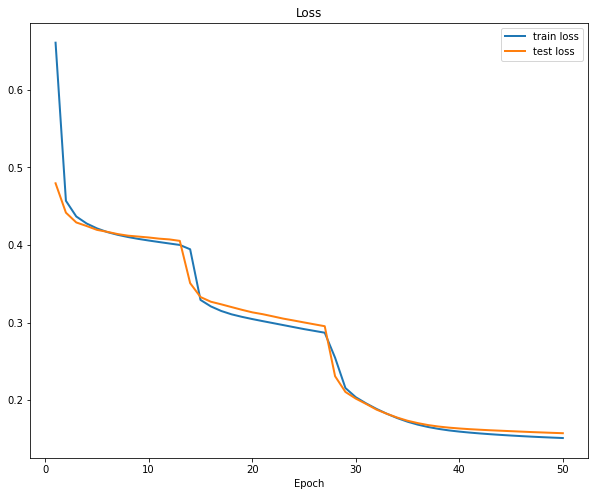

In [110]:
plot_loss_history(perceptron_2l_relu_stats_fashion[0], perceptron_2l_relu_stats_fashion[1])

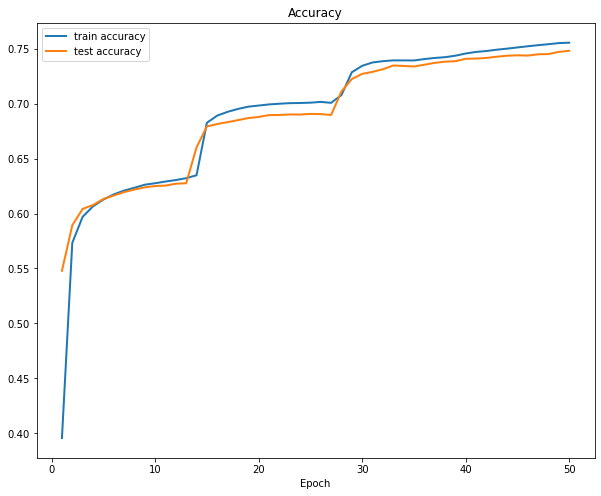

In [111]:
plot_acc_history(perceptron_2l_relu_stats_fashion[2], perceptron_2l_relu_stats_fashion[3])

In [112]:
print('Final accuracy =', perceptron_2l_relu_stats_fashion[3][-1])

Final accuracy = 0.748


In [113]:
print_confusion_matrix(perceptron_2l_relu_fashion, X_test_fashion, y_test_fashion)

[[729  19  29  70   8   1 122   1  20   1]
 [  6 961   5  21   2   1   4   0   0   0]
 [ 21   9 715  15 155   1  76   0   8   0]
 [ 27  25  16 880  29   0  20   0   3   0]
 [  2   5  84  60 740   0 101   0   8   0]
 [  1   0   2   1   2 936   0   0  17  41]
 [145  11  95  48  98   0 583   0  20   0]
 [  0   0   0   0   0 649   0   0  41 310]
 [  5   4   6   6   4   7  13   0 953   2]
 [  0   0   0   0   0  14   0   0   3 983]]


Результат уже намного лучше. Получили точность 74,8%

### Трехслойный перцептрон

Попробуем обучить трехслойный перцептрон. Будем использовать ReLU в качестве передаточной функции.

In [114]:
perceptron_3l_fashion = Model()
perceptron_3l_fashion.add(Linear(784, 128))
perceptron_3l_fashion.add(ReLU())
perceptron_3l_fashion.add(Linear(128, 32))
perceptron_3l_fashion.add(ReLU())
perceptron_3l_fashion.add(Linear(32, 10))
perceptron_3l_fashion.add(Softmax())

optimizer = SGD(1e-5)
criterion = CrossEntropyLoss()

perceptron_3l_fashion_stats = train_model(perceptron_3l_fashion, 
                                          X_train_fashion, y_train_fashion,
                                          X_test_fashion, y_test_fashion,
                                          50, 16, optimizer, criterion)

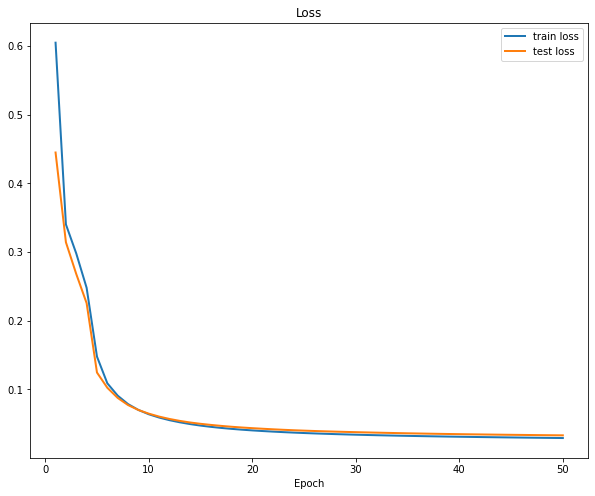

In [115]:
plot_loss_history(perceptron_3l_fashion_stats[0], perceptron_3l_fashion_stats[1])

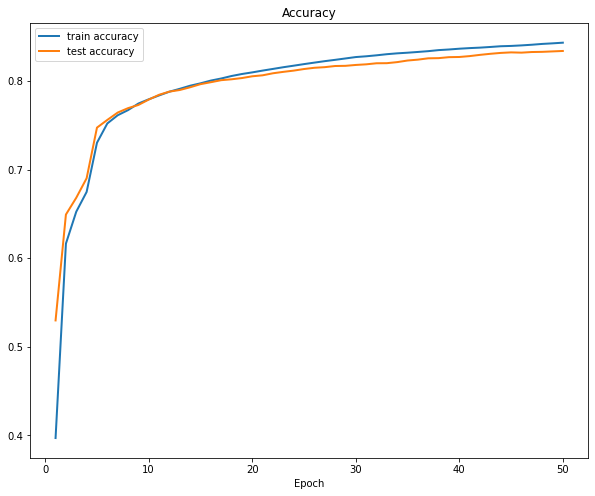

In [116]:
plot_acc_history(perceptron_3l_fashion_stats[2], perceptron_3l_fashion_stats[3])

In [117]:
print('Final accuracy =', perceptron_3l_fashion_stats[3][-1])

Final accuracy = 0.8341


In [118]:
print_confusion_matrix(perceptron_3l_fashion, X_test_fashion, y_test_fashion)

[[759   6  24  70   2   5 116   1  16   1]
 [  2 962   7  22   0   2   4   0   1   0]
 [ 17   1 758  17 128   1  66   0  12   0]
 [ 39  21  12 864  37   0  19   0   8   0]
 [  5   4 100  37 781   0  67   0   6   0]
 [  2   1   0   4   1 876   0  55   9  52]
 [140   3 105  51  93   1 584   0  23   0]
 [  0   0   0   0   0  35   0 879   3  83]
 [  6   2  11   9   7   5  13   6 939   2]
 [  0   0   0   0   0  24   0  33   4 939]]


Трехслойный перцептрон показал себя еще лучше - мы смогли получить точность 83,4%